<h1 align="center">Оптимизация гиперпараметров лучших моделей</h1>

<h2>1. 📚 Импорт библиотек и загрузка данных</h2>
<p>Загрузка предобработанных данных и лучших моделей из предыдущих этапов</p>

In [1]:
import os, sys
import pandas as pd
import numpy as np
import joblib

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

project_root = os.path.dirname(os.getcwd())
sys.path.append(project_root)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, f1_score, precision_score, recall_score, roc_auc_score

from src.data.loader import load_car_data
from src.features.preprocessing import preprocess_data

print("✅ Библиотеки загружены")

✅ Библиотеки загружены


In [2]:
df = load_car_data()
print("✅ car_data.csv загружен")

X_train_reg, X_test_reg, y_train_reg, y_test_reg = preprocess_data(df, 'price')
X_train_cl, X_test_cl, y_train_cl, y_test_cl = preprocess_data(df, 'is_premium')
print("✅ X_train, X_test, y_test, y_train готовы: ")

print("📊 Размеры данных для регрессии:")
print(f"X_train_reg: {X_train_reg.shape}")
print(f"X_test_reg: {X_test_reg.shape}") 
print(f"y_train_reg: {y_train_reg.shape}")
print(f"y_test_reg: {y_test_reg.shape}")

print("📊 Размеры данных для классификации:")
print(f"X_train_cl: {X_train_cl.shape}")
print(f"X_test_cl: {X_test_cl.shape}") 
print(f"y_train_cl: {y_train_cl.shape}")
print(f"y_test_cl: {y_test_cl.shape}")

clf = joblib.load('../models/baseline_classifier.pkl')
rfr = joblib.load('../models/random_forest_baseline.pkl')
print('✅ Модели загружены')

✅ car_data.csv загружен
✅ Создан таргет 'is_premium'
📊 Распределение: {0: 157, 1: 48}
✅ X_train, X_test, y_test, y_train готовы: 
📊 Размеры данных для регрессии:
X_train_reg: (164, 55)
X_test_reg: (41, 55)
y_train_reg: (164,)
y_test_reg: (41,)
📊 Размеры данных для классификации:
X_train_cl: (164, 55)
X_test_cl: (41, 55)
y_train_cl: (164,)
y_test_cl: (41,)
✅ Модели загружены


<h2>2. 🔧 Настройка Random Forest (Регрессия)</h2>
<p>GridSearch/BayesianOptimization для улучшения предсказания цен</p>

<h3>GridSearch для регрессии:</h3>

In [3]:
param_grid_reg = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_reg = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_reg,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("🚀 Запускаем GridSearch для Random Forest регрессии...")
grid_search_reg.fit(X_train_reg, y_train_reg)
print("✅ Поиск завершен!")

🚀 Запускаем GridSearch для Random Forest регрессии...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
✅ Поиск завершен!


In [4]:
print("🎯 Лучшие параметры:")
print(grid_search_reg.best_params_)

grid_rfr = grid_search_reg.best_estimator_

y_pred_grid_rfr = grid_rfr.predict(X_test_reg)
r2_grid_rfr = r2_score(y_test_reg, y_pred_grid_rfr)
mse_grid_rfr = mean_squared_error(y_test_reg, y_pred_grid_rfr)

print(f"📈 Результаты после настройки:")
print(f"R²: {r2_grid_rfr:.4f}")
print(f"MSE: {mse_grid_rfr:.2f}")

🎯 Лучшие параметры:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
📈 Результаты после настройки:
R²: 0.9582
MSE: 2917449.36


<h3>BayesianOptimization для регрессии:</h3>

In [5]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import cross_val_score

param_bayes_reg = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 20),
    'min_samples_split': Real(0.01, 1.0, prior='log-uniform'),
    'min_samples_leaf': Real(0.01, 0.5, prior='log-uniform'),
    'max_features': Categorical(['sqrt', 'log2']),
    'bootstrap': Categorical([True, False])
}

bayes_search_reg = BayesSearchCV(
    RandomForestRegressor(random_state=42),
    param_bayes_reg,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'
)

print("🚀 Запускаем Bayesian Optimization для Random Forest регрессии...")
bayes_search_reg.fit(X_train_reg, y_train_reg)
print("✅ Поиск завершен!")

🚀 Запускаем Bayesian Optimization для Random Forest регрессии...
✅ Поиск завершен!


In [6]:
print("🎯 Лучшие параметры:")
print(bayes_search_reg.best_params_)

bayes_rfr = bayes_search_reg.best_estimator_

y_pred_bayes_rfr = bayes_rfr.predict(X_test_reg)
r2_bayes_rfr = r2_score(y_test_reg, y_pred_bayes_rfr)
mse_bayes_rfr = mean_squared_error(y_test_reg, y_pred_bayes_rfr)

print(f"📈 Результаты после настройки:")
print(f"R²: {r2_bayes_rfr:.4f}")
print(f"MSE: {mse_bayes_rfr:.2f}")

🎯 Лучшие параметры:
OrderedDict({'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 1000})
📈 Результаты после настройки:
R²: 0.9660
MSE: 2373386.69


<h2>3. 🔧 Настройка Random Forest (Классификация)</h2>
<p>Улучшение баланса precision/recall для бинарной классификации</p>

<h3>GridSearch для классификации:</h3>

In [7]:
param_grid_clf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_clf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_reg,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("🚀 Запускаем GridSearch для Random Forest классификации...")
grid_search_clf.fit(X_train_cl, y_train_cl)
print("✅ Поиск завершен!")

🚀 Запускаем GridSearch для Random Forest классификации...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
✅ Поиск завершен!


In [8]:
y_pred_base_clf = clf.predict(X_test_cl)
f1_base = f1_score(y_test_cl, y_pred_base_clf)

grid_clf = grid_search_clf.best_estimator_
y_pred_grid_clf = grid_clf.predict(X_test_cl)
f1_grid = f1_score(y_test_cl, y_pred_grid_clf)

print(f"F1 baseline: {f1_base:.4f}")
print(f"F1 tuned:    {f1_grid:.4f}")

F1 baseline: 0.9091
F1 tuned:    0.9091


<h3>BayesianOptimization для классификации:</h3>

In [13]:
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold

param_bayes_clf = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 20),
    'min_samples_split': Real(0.01, 1.0, prior='log-uniform'),
    'min_samples_leaf': Real(0.01, 0.5, prior='log-uniform'),
    'max_features': Categorical(['sqrt', 'log2']),
    'bootstrap': Categorical([True, False]),
    'criterion': Categorical(['gini', 'entropy'])
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

bayes_search_clf = BayesSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_bayes_clf,
    n_iter=100,
    cv=cv_strategy,
    n_jobs=-1,
    random_state=42,
    scoring='f1',
    verbose=0
)

print("🚀 Запускаем Bayesian Optimization для Random Forest классификации...")
bayes_search_clf.fit(X_train_cl, y_train_cl)
print("✅ Поиск завершен!")

🚀 Запускаем Bayesian Optimization для Random Forest классификации...
✅ Поиск завершен!


In [14]:
bayes_clf = bayes_search_clf.best_estimator_
y_pred_bayes_clf = bayes_clf.predict(X_test_cl)
f1_bayes = f1_score(y_test_cl, y_pred_bayes_clf)

print(f"F1 baseline: {f1_base:.4f}")
print(f"F1 tuned:    {f1_bayes:.4f}")

F1 baseline: 0.9091
F1 tuned:    0.9167


<h3>6. 📊 Сравнение результатов до/после</h3>
<p>Анализ эффективности настройки гиперпараметров</p>

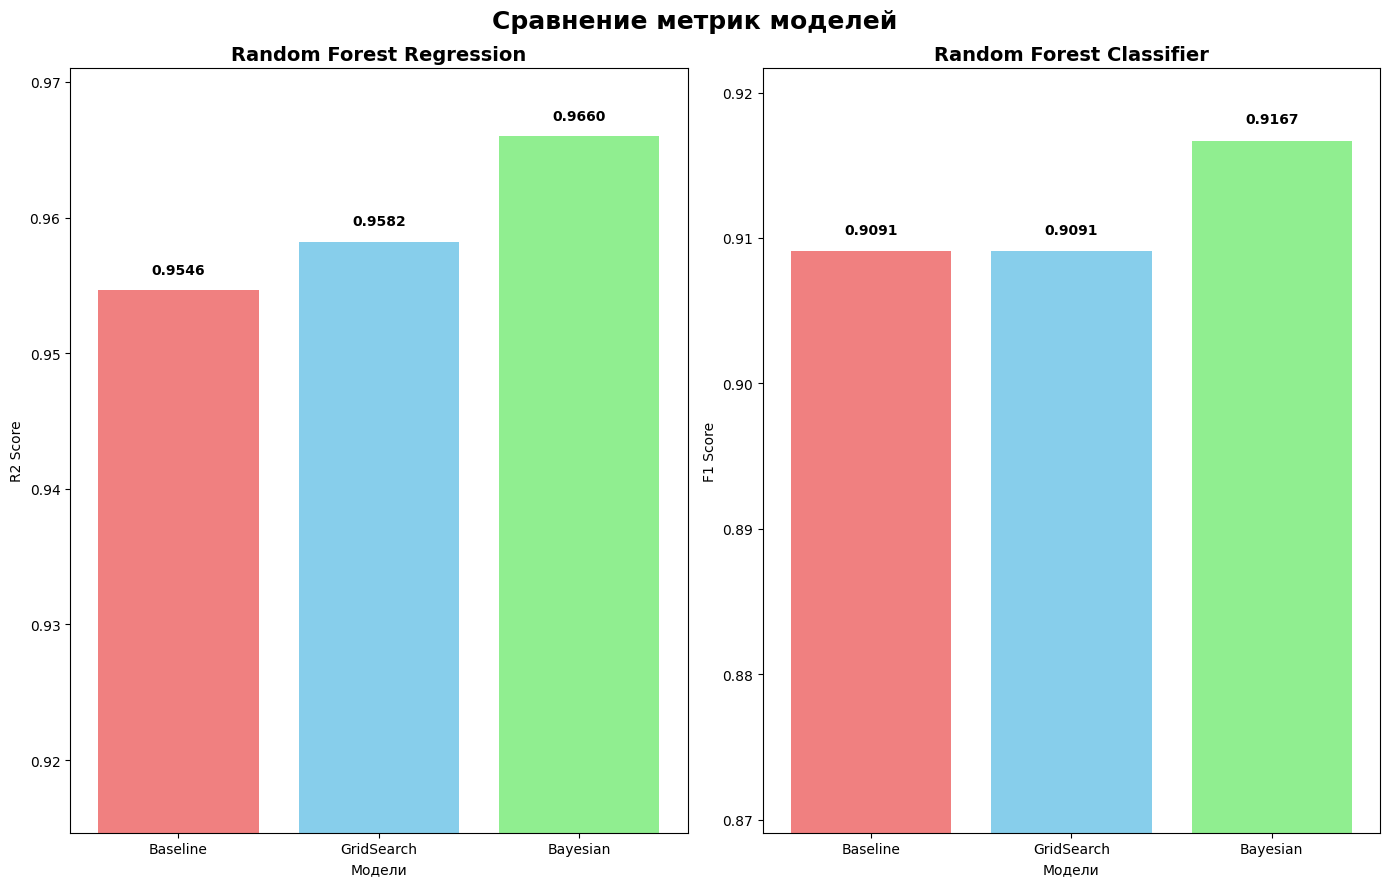

In [44]:
import matplotlib.pyplot as plt

y_pred_base_reg = rfr.predict(X_test_reg)
r2_base = r2_score(y_test_reg, y_pred_base_reg)

models = ['Baseline', 'GridSearch', 'Bayesian']
f1_scores = [f1_base, f1_grid, f1_bayes]
r2_scores = [r2_base, r2_grid_rfr, r2_bayes_rfr]
color = ['lightcoral', 'skyblue', 'lightgreen']

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 9)
fig.suptitle('Сравнение метрик моделей', fontsize=18, fontweight='bold')

bars = ax[0].bar(models, r2_scores, color=color)
ax[0].set_title('Random Forest Regression', fontsize=14, fontweight='bold')
ax[0].set_ylabel('R2 Score')
ax[0].set_xlabel('Модели')
ax[0].set_ylim([min(r2_scores) - 0.04, max(r2_scores) + 0.005])
for i, v in enumerate(r2_scores):
    ax[0].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

bars = ax[1].bar(models, f1_scores, color=color)
ax[1].set_title('Random Forest Classifier', fontsize=14, fontweight='bold')
ax[1].set_ylabel('F1 Score')
ax[1].set_xlabel('Модели')
ax[1].set_ylim([min(f1_scores) - 0.04, max(f1_scores) + 0.005])
for i, v in enumerate(f1_scores):
    ax[1].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

<h4>📊 Выводы:</h4>
<ul>
    <li><strong>Bayesian Optimization</strong> показал лучшие результаты в обеих задачах</li>
    <li>Для регрессии улучшение составило <span style="color: green;">0.0114 по R2 score</span></li>
    <li>Для классификации улучшение составило <span style="color: green;">0.0076 по F1 score</span></li>
    <li>GridSearch дал минимальное улучшение только для регрессии</li>
</ul>

<h4>🏆 Победители по метрикам:</h4>
<ul>
    <li><strong>Random Forest Regression:</strong> Bayesian Optimization (<span style="color: green;">R2 = 0.9660</span>)</li>
    <li><strong>Random Forest Classifier:</strong> Bayesian Optimization (<span style="color: green;">F1 = 0.9167</span>)</li>
</ul>

<h3>7. 💾 Сохранение оптимизированных моделей</h3>
<p>Сохранение лучших версий моделей для production</p>

In [47]:
# joblib.dump(grid_rfr, '../models/random_forest_regression_final.pkl')
joblib.dump(bayes_clf, '../models/random_forest_classifier_final.pkl')
print("✅ Модель сохранена")

✅ Модели сохранена


<h1>⚠️⚠️⚠️Примечание по модели Random Forest Regressor</h1>
<h3>В ходе проверки на продакшн-данных было выявлено, что модель <strong>Random Forest Regressor (grid_rfr)</strong> подверглась значительному переобучению. В результате ее прогнозы были некорректными и варьировались в узком неадекватном диапазоне <strong>(30 000 – 33 000)</strong>.</h3>
<h3><strong>Решение:</strong> Модель <code>grid_rfr</code> была исключена из итогового пайплайна. В дальнейшей работе используется переобученная модель из переделанного ноутбука <strong>03</strong>.</h3>